# KUBIG CONTEST
# DACON 제주도 도로 교통량 예측 AI 경진대회

# 0. Column Overview

**FEATURES**

id : 아이디  

---
*날짜 관련*

base_date : 날짜  
day_of_week : 요일  
base_hour : 시간대  

---
*도로 및 차량 관련*

road_in_use : 도로사용여부  
lane_count : 차로수  
road_rating : 도로등급  
multi_linked : 중용구간 여부  
connect_code : 연결로 코드  
maximum_speed_limit : 최고속도제한  
weight_restricted : 통과제한하중  
height_restricted : 통과제한높이  
road_type : 도로유형  
start_latitude : 시작지점의 위도  
start_longitude : 시작지점의 경도  
start_turn_restricted : 시작 지점의 회전제한 유무  
end_latitude : 도착지점의 위도  
end_longitude : 도착지점의 경도  
end_turn_restricted : 도작지점의 회전제한 유무  
road_name : 도로명  
start_node_name : 시작지점명  
end_node_name : 도착지점명  
vehicle_restricted : 통과제한차량  

---
**TARGET**  

target : 평균속도(km)  
-> *Regression model*

---
**IMPORTANT**

해당 대회에서는 외부 데이터가 사용 가능하므로 (필요 시) 어떤 외부 데이터를 쓰는 것이 좋을지 생각이 필요함.  
ex) 기후 데이터 (비오는 날이나 더운 날) / 휴일에 관한 데이터 (휴일 시 1, 아닐 시 0으로 인코딩 가능)

# Import and Reading data
Train data의 양이 많이 크기 때문에 `parquet` (파케이) 방식으로 read

In [2]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

from haversine import haversine
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# # parquet 형식으로 reading
# def csv_to_parquet(csv_path, save_name):
#     df = pd.read_csv(csv_path)
#     df.to_parquet(f'./{save_name}.parquet')
#     del df
#     gc.collect()
#     print(save_name, 'Done.')

In [4]:
# csv_to_parquet('train.csv', 'train')
# csv_to_parquet('test.csv', 'test')

In [5]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [7]:
train.head(5)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


# Data Preprocessing 
(EDA -> 예은이 / Preprocessing -> 나)  
EDA는 preprocessing의 근거를 제공하는 방식으로 선보일 예정, 전처리 역시 그에 따라 준비

**FEATURE OVERVIEW**

- id : 아이디 -> **drop**

---
*날짜 관련*

- base_date : 날짜  
    - date parsing
        - 년/월/일 or 년/월_일 or 년_월_일 로 나눠보기
        - 그대로 두고 date type으로
    - 요일과 상관성이 높지 않을까 -> 공휴일 파악하기 위함으로 두고 나중에 drop해도 될수도

- day_of_week : 요일  
    - 요일에 따라 순서대로 labeling
        - 0을 일요일으로, 1~6 : 월~토

- base_hour : 시간대  
    - 0~23
        - 등하교, 출퇴근 시간 고려 : 아마 모델링에서 해당 수치들에 가중치가 붙지 않을까?
        - target이 평균 속도인만큼, 차량이 많다 = 차가 막힌다 = 속도 저하 : 추측

---
*도로 및 차량 관련*

- lane_count : 차로수  
    - 차로가 많다 = 많은 양의 차가 한번에 통과 가능하다 = 차의 유동성이 높다 = 속도 높게 이동 가능 : 추측

**필요한 정보와 관련된 표**

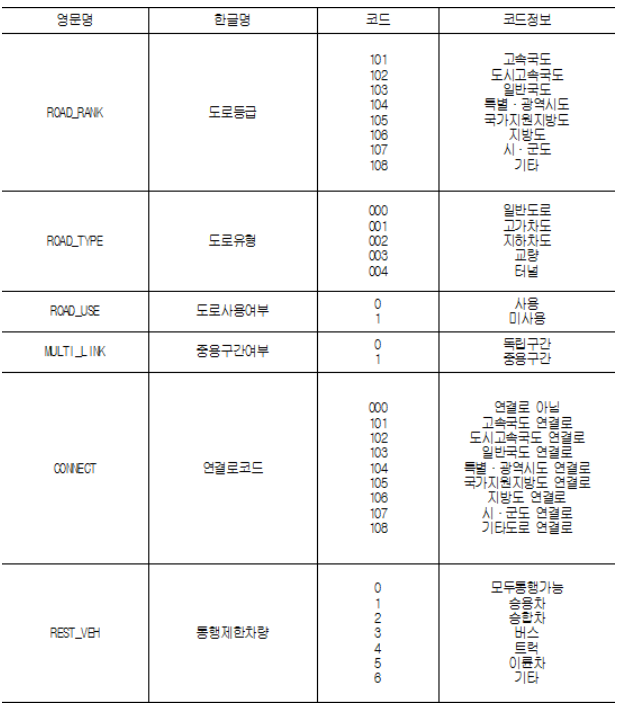  

출처 :  
[<지능형교통체계 표준 노드·링크 구축기준 [시행 2015. 10. 16.] [국토교통부고시 제2015-756호, 2015. 10. 16., 일부개정]>](https://www.law.go.kr/LSW/admRulInfoP.do?admRulSeq=2100000029728)


- road_rating : 도로등급  
    - `train.road_rating.unique()`와 `test.road_rating.unique()` 돌려본 결과 
        - 103 : 일반 국도, 106 : 지방도, 107 : 시도, 군도 밖에 안나옴
    - 고속도로는 *없음*

- multi_linked : 중용구간 여부  
    - 중용구간이란? 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간 [(출처)](https://www.semanticscholar.org/paper/%EC%9D%BC%EB%B0%98%EA%B5%AD%EB%8F%84-%EC%A4%91%EC%9A%A9%EA%B5%AC%EA%B0%84%EC%9D%98-%EC%8B%9C%EA%B0%84%EC%A0%81-%EC%A0%95%EB%B3%B4%EA%B4%80%EB%A6%AC%EC%97%90-%EB%8C%80%ED%95%9C-%EC%97%B0%EA%B5%AC-%EC%84%9C%EC%9E%AC%ED%99%94-%EC%84%B1%EC%A0%95%EA%B3%A4/5c905f83ce13879d65c10fc1c92b1ef20d3b402f)
    - 0이 아님, 1이 맞음으로 추정

- connect_code : 연결로 코드  
    - 아마 해당 도로가 연결되는 점이 어디인가 인듯
    - connect_code 103이 있길래 road_rating과 같은지 확인 위하여 코드로 확인해본 결과 '일반국도12호선', '일반국도95호선'만 나옴
        - 해당 값들에 대해 좀 리서치 해야할듯
        - 코드: `train.loc[train['road_rating']==103].loc[train['connect_code']==103].road_name.unique()`

- maximum_speed_limit : 최고속도제한  
    - 어린이 제한 구역?
    - 속도 제한이 낮다 = 차들이 느리게 갈 수 밖에 없다 = 속도 저하
    - target과 가공 없는 상태에서 봤을때 가장 관련성 자체는 높아 보이는 feature

- weight_restricted : 통과제한하중  
    - `train.weight_restricted.unique()`와 `test.weight_restricted.unique()`로 검증 결과
    - 32400., 0., 43200., 50000. : 4가지의 값들만 존재
    - 이는 제한 하중의 유무로 그냥 0과 1로 나누어도 될수도

- height_restricted : 통과제한높이  
    - train, test에서 모두 0 -> **drop**

- road_type : 도로유형  
    - `unique()` 돌려본 결과 0, 3 밖에 없음
    - 0 : 일반도로, 3 : 교량

- start_latitude : 시작지점의 위도 & start_longitude : 시작지점의 경도  
    - concat하여 start_point 로 파생변수 생성 가능할 듯

- end_latitude : 도착지점의 위도 & end_longitude : 도착지점의 경도  
    - concat하여 end_point 로 파생변수 생성 가능할 듯

- start_turn_restricted : 시작 지점의 회전제한 유무 & end_turn_restricted : 도작지점의 회전제한 유무
    - 회전제한유무 : 좌회전금지, 우회전금지, U-Turn 등 교차로에서의 회전제한 (출처는 표와 동일)
    - target과 어떤 연관성이 있을지는 의문

- road_name : 도로명  
    - 도로별로 묶어서 분석? 어떻게 전처리해야할지 논의해봐야함 (**예은 주목**)

- start_node_name : 시작지점명 & end_node_name : 도착지점명  
    - start_point, end_point (위도 경도)와 엮을 수 있을 듯

- vehicle_restricted : 통과제한차량  
    - 전 데이터에서 0 -> **drop**

---

외부 데이터?  
- 기후 데이터 (비오는 날이나 더운 날) -> 기상청에서 데이터 [여기서](https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179) 옵션 조절 후 다운로드 가능
- 휴일에 관한 데이터 (휴일 시 1, 아닐 시 0으로 인코딩 가능)
    - [2021년 공휴일 데이터](https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=2021+%EA%B3%B5%ED%9C%B4%EC%9D%BC&oquery=2022+%EA%B3%B5%ED%9C%B4%EC%9D%BC&tqi=h2u%2FLdprvh8ssMTI%2BEwssssssud-119076)
    - [2022년 공휴일 데이터](https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=2022+%EA%B3%B5%ED%9C%B4%EC%9D%BC&oquery=2021+%EA%B3%B5%ED%9C%B4%EC%9D%BC&tqi=h3Lx0sprvh8ssPXKm8hssssss98-520113)
- [날짜별 관광객 입도 현황](https://www.jeju.go.kr/open/open/iopenboard.htm?category=1035)
- 공항과의 거리 -> 어떻게 계산할 것인가

## Preprocessing
순서는 최대한 위의 컬럼 설명 순서에 따라서 진행

In [8]:
# id, height_restricted, vehicle_restricted은 전 데이터에 걸쳐 0이므로 drop
train.drop(columns=['id', 'height_restricted', 'vehicle_restricted'], inplace=True)
test.drop(columns=['id', 'height_restricted', 'vehicle_restricted'], inplace=True)

## 시간 관련 데이터
- <교통 통계 정보를 이용한 속도 패턴 예측에 관한 연구> (2009, 최보승)의 논문 참고, 시간별, 요일별, 주말 및 공휴일에 대한 정보 중요도에 따라 아래 feature들을 만들었음

### 1. 날짜 관련
- date type 형태의 컬럼 (date)
- 년, 월, 일 컬럼 (year, month, day)
- 계절 (분기) (season)
- 공휴일 전후일인지 아닌지 여부 (holiday)

In [9]:
# base_date 전처리- date type으로 처리
train['date'] = pd.to_datetime(train['base_date'], format='%Y%m%d')
test['date'] = pd.to_datetime(train['base_date'], format='%Y%m%d')

In [10]:
# date 전처리- 년, 월, 일 컬럼 추가
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

In [11]:
# date 전처리- 년+월만 있는 컬럼 추가 (입도 현황)
train['year_month'] = train['base_date'].astype(str).str[:6]
test['year_month'] = test['base_date'].astype(str).str[:6]

In [12]:
# date 전처리- 계절 컬럼 추가 (반복문보다 함수화가 더 빨라서 이렇게 진행)
def seasons(i) :
    if i in [3, 4, 5] :
        return 'spring'
    elif i in [6, 7, 8] :
        return 'summer'
    elif i in [9, 10, 11] :
        return 'fall'
    else :
        return 'winter'

train['season'] = train['month'].apply(seasons)
test['season'] = test['month'].apply(seasons)


In [13]:
# 2021, 2022 공휴일 +- 1일에 대한 리스트
holidays = ['20210101', '20210102', 
            '20210210', '20210211', '20210212', '20210213', '20210214'
            '20210228', '20210301', '20210302',
            '20210504', '20210505', '20210506',
            '20210518', '20210519', '20210520',
            '20210607', '20210606', '20210607',
            '20210814', '20210815', '20210816', '20210817'
            '20210919', '20210920', '20210921', '20210922', '20210923'
            '20211002', '20211003', '20211004', '20211005',
            '20211008', '20211009', '20211010', '20211011', '20211012',
            '20211226', '20211225', '20211227'

            '20211231', '20220101', '20220102',
            '20220130', '20220131', '20220201', '20220202', '20220203',
            '20220228', '20220301', '20220302',
            '20220308', '20220309', '20220310',  
            '20220504', '20220505', '20220506',
            '20220507', '20220508', '20220509',
            '20220531', '20220601', '20220602',
            '20220814', '20220815', '20220816',
            '20220908', '20220909', '20220910', '20220911', '20220912', '20220913',
            '20221002', '20221003', '20221004',
            '20221008', '20221009', '20221010', '20221011',
            '20221224', '20221225', '20221226']

train['holiday'] = train['base_date'].astype(str).isin(holidays)
test['holiday'] = test['base_date'].astype(str).isin(holidays)

In [14]:
# 휴가철
vacation = [12, 1, 2, 6, 7, 8]

def vacations(i) :
    if i in vacation :
        return 'yes'
    else :
        return 'no'

train['vacation'] = train['month'].apply(vacations)
test['vacation'] = test['month'].apply(vacations)

### 2. 요일
- '일':1, '월':2, '화':3, '수':4, '목':5, '금':6, '토':7
- 주말인지 아닌지 여부 컬럼 추가 (weekend)
- CatBoost의 경우 해당 과정 없이 그냥 cat_features로 적용시켜도 가능은 할거임

In [15]:
# 요일 -> 숫자 (일요일 시작)
days = {'일':1, '월':2, '화':3, '수':4, '목':5, '금':6, '토':7}

train['day_of_week'] = train['day_of_week'].replace(days)
test['day_of_week'] = test['day_of_week'].replace(days)

In [16]:
# 주말인가?
def weekends(i) :
    if i in [1, 7] :
        return 'yes'
    else :
        return 'no'

train['weekend'] = train['day_of_week'].apply(weekends)
test['weekend'] = test['day_of_week'].apply(weekends)

### 3. 시간대
- base_hour을 오전, 오후, 저녁, 새벽으로 나눔 (time)
- 등하교, 출퇴근 시간(7~9시, 17~19시)인지 여부 컬럼 추가 (rush hour)

In [17]:
# 오전, 오후, 저녁, 새벽으로 나눔 (6시간 단위)
def times(i) :
    if i in [6, 7, 8, 9, 10, 11] :
        return 'morning'
    elif i in [12, 13, 14, 15, 16, 17] :
        return 'noon'
    elif i in [18, 19, 20, 21, 22, 23] :
        return 'night'
    else :
        return 'dawn'

train['time'] = train['base_hour'].apply(times)
test['time'] = test['base_hour'].apply(times)

In [18]:
# 등하교, 출퇴근, 주말은 전부 rush_hour이 아닌거로
def rush_hours(i) :
    if i in [7, 8, 9, 17, 18, 19] :
        return 'yes'
    else :
        return 'no'

train['rush_hour'] = train['base_hour'].loc[train['weekend']=='no'].apply(rush_hours)
train['rush_hour'].fillna('no', inplace=True)
test['rush_hour'] = test['base_hour'].loc[train['weekend']=='no'].apply(rush_hours)
test['rush_hour'].fillna('no', inplace=True)

## 도로 관련 데이터

- `lane_count`, `road_rating` : 그대로 유지
- `multi_linked`, `connect_code` : test에서 전부 전부 0임 -> train, test에서 잡음만 줄것으로 판단되어 **drop**
- `maximum_speed_limit` : 최고 제한 속도보다 target이 빠른 경우 제거
- `weight_restricted` : 범주화
- `road_type` : 그대로 두기 (범주형 변수로 처리) / `road_rating`과 묶어서 하나의 변수로도 처리해봄
- `start_latitude & start_longitude` 와 `end_latitude & end_longitude`
    - 제주도의 위-경도에서 벗어난 지역이 있을까? ([참고](https://www.investkorea.org/jj-kr/cntnts/i-1157/web.do))
        - 33.190833~33.563889 / 126.145278~126.972222 (도분초 변환 한거임)
    - `haversine`으로 거리 계산 ([참고](https://stricky.tistory.com/284))
    - 시작지점과 종착지점의 위-경도를 cluster하여 위치적으로 제주에서의 구역을 범주화할 수 있을듯
- `start_turn_restricted`과 `end_turn_restricted`은 합해서 `turn_restricted`으로 처리
- `start_node_name & end_node_name` : 위의 위-경도로 처리, **drop**
- `road_name` : 도로별 시간-요일에 따라 grouping 후 평균 계산 - <교통 통계 정보를 이용한 속도 패턴 예측에 관한 연구> (2009, 최보승)의 논문 참고

In [19]:
# multi_linked, connect_code, start_node_name, end_node_name drop
train.drop(columns=['multi_linked', 'connect_code', 'start_node_name', 'end_node_name'], inplace=True)
test.drop(columns=['multi_linked', 'connect_code', 'start_node_name', 'end_node_name'], inplace=True)

In [20]:
# maximum_speed_limit : 최고 제한 속도보다 target이 빠른 경우 제거 (만약 성능 떨어지면 빼고 해도됨)
train[(train['maximum_speed_limit']<train['target'])].head()


,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,maximum_speed_limit,weight_restricted,road_type,start_latitude,...,year,month,day,year_month,season,holiday,vacation,weekend,time,rush_hour
9,20211208,4,2,1,103,일반국도16호선,50.0,0.0,0,33.361717,...,2021,12,8,202112,winter,False,yes,no,dawn,no
15,20220501,1,16,1,103,일반국도16호선,30.0,0.0,0,33.478001,...,2022,5,1,202205,spring,False,no,yes,noon,no
28,20220612,1,14,2,107,-,50.0,0.0,0,33.330822,...,2022,6,12,202206,summer,False,yes,yes,noon,no
69,20220214,2,4,1,106,지방도97호선,60.0,0.0,0,33.408913,...,2022,2,14,202202,winter,False,yes,no,dawn,no
73,20211023,7,15,2,106,지방도1118호선,50.0,43200.0,3,33.285638,...,2021,10,23,202110,fall,False,no,yes,noon,no


In [21]:
print(len(train[(train['maximum_speed_limit']<train['target'])]) / len(train)) # 대략 9.7%의 데이터 drop 예정

0.0978055256755857


In [22]:
train = train.loc[train['maximum_speed_limit']>=train['target']]

In [23]:
# weight_restricted 범주화
print(train['weight_restricted'].unique())
print(test['weight_restricted'].unique())

[32400.     0. 43200. 50000.]
[    0. 43200. 32400. 50000.]


In [24]:
# 1. 무게별로 범주 다르게
weights = {0:0, 32400:1, 43200:2, 50000:3}

train['weight_restricted'] = train['weight_restricted'].astype(int).replace(weights)
test['weight_restricted'] = test['weight_restricted'].astype(int).replace(weights)

In [25]:
# # 2. target이 비슷한것끼리 범주화 (1을 쓰지 않는 경우 이렇게도 활용 가능)
# weights = {0:0, 32300:1, 50000:1, 43200:2}

# train['weight_restricted'] = train['weight_restricted'].replace(weights)
# test['weight_restricted'] = test['weight_restricted'].replace(weights)

In [26]:
# road_type과 road_rating 묶어서 범주로 (만약 따로따로 넣는게 낫다면 해당 코드 안써도 됨)
train['road_type_rating'] = train['road_rating'].astype(str)+'_'+train['road_type'].astype(str)
test['road_type_rating'] = test['road_rating'].astype(str)+'_'+test['road_type'].astype(str)

In [27]:
train['road_type_rating'].unique() # 총 6가지 종류 다 나옴

array(['106_3', '103_0', '107_0', '107_3', '106_0', '103_3'], dtype=object)

In [28]:
# # road_type, road_rating drop (이건 필요하다고 생각하면 각주 해제 후 사용할 것)
# train.drop(columns=['road_rating', 'road_type'], inplace=True)
# test.drop(columns=['road_rating', 'road_type'], inplace=True)

In [29]:
train['start_turn_restricted'].unique()

array(['없음', '있음'], dtype=object)

In [30]:
# start_turn_restricted와 end_turn_restricted encoding
yes_no = {'없음':0, '있음':1}

train['start_turn_restricted'] = train['start_turn_restricted'].replace(yes_no)
test['start_turn_restricted'] = test['start_turn_restricted'].replace(yes_no)
train['end_turn_restricted'] = train['end_turn_restricted'].replace(yes_no)
test['end_turn_restricted'] = test['end_turn_restricted'].replace(yes_no)

In [31]:
# 이를 합친 turn_restricted
train['turn_restricted'] = train['start_turn_restricted'] + train['end_turn_restricted']
test['turn_restricted'] = test['start_turn_restricted'] + train['end_turn_restricted']

In [32]:
# # start_turn_restricted와 end_turn_restricted drop (필요시 주석 해제 후 사용)
# train.drop(columns=['start_turn_restricted', 'end_turn_restricted'], inplace=True)
# test.drop(columns=['start_turn_restricted', 'end_turn_restricted'], inplace=True)

In [33]:
# 위-경도 작업
# 1. 제주도 내에 있는 지역만 남기기 -> 확인
len(train.loc[train['start_latitude'].between(33.190833, 33.563889, inclusive=True) & train['start_longitude'].between(126.145278, 126.972222, inclusive=True)]) / len(train)

1.0

In [34]:
len(train.loc[train['end_latitude'].between(33.190833, 33.563889, inclusive=True) & train['end_longitude'].between(126.145278, 126.972222, inclusive=True)]) / len(train)
# 모두 제주도 내의 지역들에 대한 데이터임

1.0

In [35]:
# 2. 거리 계산 함수
def distance(x) :
    start_location = tuple(zip(x['start_latitude'], x['start_longitude']))
    end_location = tuple(zip(x['end_latitude'], x['end_longitude']))
    hsine = [haversine(s, e, unit='km') for s, e in zip(start_location, end_location)]
    return hsine

train['road_distance'] = distance(train)
test['road_distance'] = distance(test)

In [36]:
# 3. 구역 Clustering
def make_cluster(x) : 
    x_lat_long = x[['start_latitude', 'start_longitude']]

    k_mean = KMeans(n_clusters=6, max_iter=1000, random_state = 31)
    location_cluster = k_mean.fit_predict(x_lat_long)
    return location_cluster

train['location_cluster'] = make_cluster(train)
test['location_cluster'] = make_cluster(test)

In [37]:
# 도로명 확인
train.road_name.unique() # '-'가 존재함 -> drop 사유가 될 수 있음

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '신산로', '신광로', '지방도1136호선', '첨단로', '제2거로교', '시민광장로', '임항로',
       '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로', '관광단지2로', '아봉로', '호근로',
       '관광단지1로'], dtype=object)

In [38]:
# 도로명에 - 라는 결측치가 존재함으로 확인되므로 확실한 시작-끝 지점 위-경도를 사용
train['road_lat_long'] = train['start_latitude'].astype(str)+'_'+train['start_longitude'].astype(str)+'_'+train['end_latitude'].astype(str)+'_'+train['end_longitude'].astype(str)
test['road_lat_long'] = test['start_latitude'].astype(str)+'_'+test['start_longitude'].astype(str)+'_'+test['end_latitude'].astype(str)+'_'+test['end_longitude'].astype(str)

In [39]:
# road_lat_long은 너무 길기 때문에 label encoding 우선 진행
le = LabelEncoder()
train['road_lat_long'] = le.fit_transform(train['road_lat_long'])
test['road_lat_long'] = le.fit_transform(test['road_lat_long'])

In [40]:
# 위-경도로된 도로별 시간별 / 요일별 속도 평균 평균 계산
# 도로별 시간별 속도 평균
train['road_hour'] = train['road_lat_long'].astype(str)+'_'+train['base_hour'].astype(str)
test['road_hour'] = test['road_lat_long'].astype(str)+'_'+test['base_hour'].astype(str)

hour_mean = train.groupby(['road_hour'])[['target']].agg('mean').reset_index()
hour_mean.columns = ['road_hour', 'road_hour_mean']
train = train.merge(hour_mean, how='left', on='road_hour')
test = test.merge(hour_mean, how='left', on='road_hour')


In [41]:
# 도로별 요일별 속도 평균
train['road_day'] = train['road_lat_long'].astype(str)+'_'+train['day_of_week'].astype(str)
test['road_day'] = test['road_lat_long'].astype(str)+'_'+test['day_of_week'].astype(str)

hour_mean = train.groupby(['road_day'])[['target']].agg('mean').reset_index()
hour_mean.columns = ['road_day', 'road_day_mean']
train = train.merge(hour_mean, how='left', on='road_day')
test = test.merge(hour_mean, how='left', on='road_day')

In [42]:
# # 이상치 제거 함수 - 이상치를 제거해야할 column을 못찾겠어서 사용하지 않았으나 필요시 사용해볼것
# def outlier_detect(cols, df) :
#     for col in cols :
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         iqr = Q3 - Q1
#         df = df[(df[col] <= 1.5 * Q3) & (df[col] >= 1.5 * Q1)]
#         df = df.reset_index(drop=True)
#     return df

In [43]:
# # 이상치를 제거해야하는 columns
# remove_outliers_cols = []

## 외부 데이터
- 제주도 입도 관광객 현황

In [44]:
# 제주도 입도 관광객 현황
# 수집해야하는 년-월 파악
np.sort(train.year_month.unique())

array(['202109', '202110', '202111', '202112', '202201', '202202',
       '202203', '202205', '202206', '202207'], dtype=object)

In [45]:
# 입도 관관갱 컬럼 (inflow)
inflow_train = pd.DataFrame({'year_month':['202109', '202110', '202111', '202112', '202201', '202202',
       '202203', '202205', '202206', '202207'],
       'inflow':[872396, 1222094, 1204344, 1090607, 1170802, 1029503, 873086, 1306537, 1283470, 1263332]})
inflow_test = pd.DataFrame({'year_month' : '202208', 'inflow': [1281608]})

train = train.merge(inflow_train, how='left', on='year_month')
test = test.merge(inflow_test, how='left', on='year_month')

In [335]:
train.columns # 여기서 자유롭게 선택과 drop의 조합을 testing하여 모델 성능 끌어올려보기

Index(['base_date', 'day_of_week', 'base_hour', 'lane_count', 'road_rating',
       'road_name', 'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_latitude', 'start_longitude', 'start_turn_restricted',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target',
       'date', 'year', 'month', 'day', 'season', 'holiday', 'vacation',
       'weekend', 'time', 'rush_hour', 'road_type_rating', 'turn_restricted',
       'road_distance', 'location_cluster', 'road_lat_long', 'road_hour',
       'road_hour_mean', 'road_day', 'road_day_mean'],
      dtype='object')